## User configuration

In [16]:
config_name = "ESM-1b"
#config_name = "ESM-IF"
#config_name = "ESM-IF_replication"

# Studied protein names
protein1_name = "dF106"
#protein1_name = "MM9"
#protein1_name = "eMM9"
#protein1_name = "1fb0"
#protein2_name = "dF106"
protein2_name = "edF106"

# Options used for difference on position plot
#options_difference_on_position = ["max", "min", "mean", "median",]
options_difference_on_position = ["max", "min", "mean", "median", "std"]

# Specify the structures used to make the results
if config_name == "ESM-IF":
    # In general
    #structure1_name = "[model name]/[sequence used]/[template used]/[MSA config]"
    #structure2_name = "[model name]/[sequence used]/[template used]/[MSA config]"

    # 1FB0 template
    #structure1_name = "AF2_config/1fb0/1FB0/single_sequence/"

    # 5J7D template
    structure1_name = "AF2_config/dF106/5J7D/single_sequence/"
    #structure1_name = "AF2_config/MM9/5J7D/single_sequence/"
    structure2_name = "AF2_config/edF106/5J7D/single_sequence/"
    
    # None template
    #structure1_name = "AF2_config/dF106/None/single_sequence/"
    #structure2_name = "AF2_config/edF106/None/single_sequence/"

if config_name == "ESM-IF_replication":
    structure1_name = "AF2_config/dF106/5J7D/single_sequence/"
    structure2_name = "AF2_config/dF106/5J7D/single_sequence/"
    if (protein1_name != 'dF106') | (protein2_name != 'dF106'):
        raise Exception("The replication option is done only for dF106 yet!")



## Preparation

### Repository configuration

In [17]:
# Prepare inputs

# Define fixed parts
ESM1b_prefix = "../data/ESM_results/ESM-1b/"
ESMIF_prefix = "../data/ESM_results/ESM-IF/"
suffix = "_results.txt"

# Set which outputs to use
# ESM-1b
if config_name == "ESM-1b":
    prefix = ESM1b_prefix
    suffix = suffix

    #output_name = "ESM-1b, v4 results"
    output_name = "ESM-1b"
    save_as = "../results/ESM-1b"

# ESM-IF
elif config_name == "ESM-IF":
    prefix = ESMIF_prefix

    #output_name = "ESM-IF, v4 results"
    output_name = "ESM-IF"
    save_as = "../results/ESM-IF"

elif config_name == "ESM-IF_replication":
    prefix1 = "../data/ESM_results/ESM-IF/"
    prefix2 = "../data/ESM_results/ESM-IF/replication/"

    output_name = "ESM-IF vs replication results"
    save_as = "../results/ESM-IF_replication"

else: raise Exception("No correct option chosen.")

### Fixed parts - protein preparation

In [18]:
import numpy as np
import pandas as pd

# Proteins are represented as a dict like this
protein = {
    "name": "",
    "filename": "",
    "sequence": "",
    "result": "pd.DataFrame"
}

protein_names = ["1fb0", "dF106", "edF106", "MM9", "eMM9"]

sequences = {
    "1fb0"  : "VQDVNDSSWKEFVLESEVPVMVDFWAPWCGPCKLIAPVIDELAKEYSGKIAVYKLNTDEAPGIATQYNIRSIPTVLFFKNGERKESIIGAVPKSTLTDSIEKYL",
    "dF106" : "VLDVTKDHWLLYVLLAQLPVMVLFRKDNDEEAKKVEYIVRELAQEFDGLIMVFELDTNKAPEIAKKYNITTTPTVAFFKNGEDKSVLIGAIPKDQLRDEILKYL",
    "edF106": "VLDVTKDHWLPYVLLAQLPVMVLFRKDNDEEAKKVEYIVRELAQEFDGLIMVFELDTNKAPEIAKKYNITTTPTVAFFKNGEVKSVLIGAIPKDQLRDEILKYL",
    "MM9"   : "VLDVTKDHWLPYVLLAQLPVMVLFRKDNDEEAKKVEYIVRELAQEFDGLIRVFYVDINKAPEIAKKYNITTTPTVAFFHNGELKSVFTGAITKDQLRDEILKYL",
    "eMM9"  : "VLDVTKDHWLPYVLLAQLPVMVLFRKDNDEEAKKVEYIVRELAQEFDGLIKVFVVDINKAPEIAKKYNITTTPTVAFFKNGELKSVFTGAISKDQLRDEILKYL",
}

# Make dict of proteins
if config_name == 'ESM-1b':
    proteins = {
            protein1_name: {
            "name": protein1_name,
            "filename": prefix+protein1_name+suffix,
            "sequence": sequences[protein1_name],
            },
            protein2_name: {
            "name": protein2_name,
            "filename": prefix+protein2_name+suffix,
            "sequence": sequences[protein2_name],
            }
        }
elif config_name == 'ESM-IF':
    proteins = {
            protein1_name: {
            "name": protein1_name,
            "filename": prefix+structure1_name+protein1_name+suffix,
            "sequence": sequences[protein1_name],
            },
            protein2_name: {
            "name": protein2_name,
            "filename": prefix+structure2_name+protein2_name+suffix,
            "sequence": sequences[protein2_name],
            }
        }
    
elif config_name in ["ESM-IF_replication"]:
    proteins = {
            protein1_name: {
            "name": protein1_name,
            "filename": prefix1+structure1_name+protein1_name+suffix,
            "sequence": sequences[protein1_name],
            },
            protein2_name: {
            "name": protein2_name,
            "filename": prefix2+structure2_name+protein2_name+suffix,
            "sequence": sequences[protein2_name],
            }
        }

protein1 = proteins[protein1_name]
protein2 = proteins[protein2_name]

In [19]:
# Check the proteins
protein1, protein2

({'name': 'dF106',
  'filename': '../data/ESM_results/ESM-1b/dF106_results.txt',
  'sequence': 'VLDVTKDHWLLYVLLAQLPVMVLFRKDNDEEAKKVEYIVRELAQEFDGLIMVFELDTNKAPEIAKKYNITTTPTVAFFKNGEDKSVLIGAIPKDQLRDEILKYL'},
 {'name': 'edF106',
  'filename': '../data/ESM_results/ESM-1b/edF106_results.txt',
  'sequence': 'VLDVTKDHWLPYVLLAQLPVMVLFRKDNDEEAKKVEYIVRELAQEFDGLIMVFELDTNKAPEIAKKYNITTTPTVAFFKNGEVKSVLIGAIPKDQLRDEILKYL'})

## Load results

In [20]:
def parse_result(protein):
    # Get relevant lines (no header and comments) from file
    relevant_lines = []
    with open(protein["filename"]) as file:
        relevant_lines = list(filter(lambda line: (line[0] != "#") & (line != "variant masked-marginals\n"),file.readlines()))

    # Process each line
    scores = []
    mut_from = []
    mut_position = []
    mut_to = []

    for line in relevant_lines:
        mutation, score = line.split()
        mut_from.append(mutation[ 0])
        mut_to.append  (mutation[-1])
        mut_position.append(int(mutation[1:-1]))
        scores.append(float(score))
    
    return pd.DataFrame({"from": mut_from, "position": mut_position, "to": mut_to, "score": scores})

def prepare_dataframes(protein1, protein2):
    # Find different positions in the protein sequence
    seq1 = protein1["sequence"]
    seq2 = protein2["sequence"]
    if len(seq1) == len(seq2):
        seq_len = len(seq1)
    else:
        raise Exception("The length of the protein sequences differ!")

    changed_positions = [i+1 for i in range(seq_len) if seq1[i] != seq2[i]]
    substitutions = [f"{seq1[ch-1]}{ch}{seq2[ch-1]}" for ch in changed_positions]

    df_prot1 = parse_result(protein1)
    df_prot2 = parse_result(protein2)

    # Don't take mutated positions into account?
    if False:
        df_prot1 = df_prot1[~df_prot1["position"].isin(changed_positions)]
        df_prot2 = df_prot2[~df_prot2["position"].isin(changed_positions)]

    return df_prot1, df_prot2, changed_positions, substitutions

def check_data_organized_the_same(protein1, protein2, changed_positions=None) -> bool:
    df_prot1 = protein1["result"]
    df_prot2 = protein2["result"]

    # Don't take changed positions into account
    if changed_positions!=None:
        df_prot1 = df_prot1[~df_prot1["position"].isin(changed_positions)]
        df_prot2 = df_prot2[~df_prot2["position"].isin(changed_positions)]

    # Check wheter the proteins are organized the same way - if the aminoacids are aligned:
    if df_prot1.shape[0] == df_prot2.shape[0]:
        len_df = df_prot1.shape[0]
    else:
        raise Exception("The dataframes have different length!")

    test_array = np.zeros(shape=len_df, dtype='bool')
    for i in range(len_df):
        same_from     = df_prot1.iloc[i][    "from"] == df_prot2.iloc[i][    "from"]
        same_position = df_prot1.iloc[i]["position"] == df_prot2.iloc[i]["position"]
        same_to       = df_prot1.iloc[i][      "to"] == df_prot2.iloc[i][      "to"]
        test_array[i] = same_from & same_position & same_to

    return test_array.min()


In [21]:
# Load the proteins into dataframes
protein1["result"], protein2["result"], changed_positions, substitutions = prepare_dataframes(protein1, protein2)
print(f"Following positions differ in sequences:\n{changed_positions}\n")
print(f"List of substitutions between {protein1['name']} and {protein2['name']}:\n{substitutions}\n")
print(f"The sequences differ on {len(changed_positions)} positions.\n")

# Check, if the dataframes are organized the same way
# = mutations are the same (from, position and to fields)
print(f"Are the dataframes organized the same?\n{check_data_organized_the_same(protein1, protein2, changed_positions)}")

Following positions differ in sequences:
[11, 83]

List of substitutions between dF106 and edF106:
['L11P', 'D83V']

The sequences differ on 2 positions.

Are the dataframes organized the same?
True


## Charts

### Scatter plot

In [22]:
def find_outliers(df_prot1, df_prot2, settings: dict):
    differences = compute_differences(df_prot1, df_prot2)
    df_merged = pd.merge(df_prot1, df_prot2, on=['from', 'to', 'position'], suffixes=('_prot1', '_prot2'))
    df_merged["differences"]=differences

    # Set the threshold
    if settings["mode"]=="fixed":
        threshold = settings["value"]
    elif settings["mode"]=="percentil":
        percentil = settings["value"]
        threshold = df_merged["differences"].quantile(percentil)
    else: raise Exception("Wrong settings passed to the function.")
    
    df_outliers = df_merged[np.abs(df_merged["differences"])>threshold]
    
    return df_outliers

def scores_scatter(protein1, protein2, title=None, save_as = None, df_outliers=None, iloc=None):
    import matplotlib.pyplot as plt

    # Merging DataFrames on 'from', 'position', and 'to' columns
    merged_df = pd.merge(protein1["result"], protein2["result"], on=['from', 'position', 'to'], suffixes=('_protein1', '_protein2'))

    # Extracting scores for the scatter plot
    x_scores = merged_df['score_protein1']
    y_scores = merged_df['score_protein2']

    # Create the scatter plot
    plt.figure(figsize=(8, 8))
    plt.scatter(x_scores, y_scores, color='blue', label='Score Pairs')

    ## Cover outliers by red dot
    #x_outlier_scores = df_outliers.iloc[iloc]['score_prot1']
    #y_outlier_scores = df_outliers.iloc[iloc]['score_prot2']
    #plt.scatter(x_outlier_scores, y_outlier_scores, color='red', label='Score Pairs')

    # Plot y = x line
    min_x = x_scores.min()
    max_x = x_scores.max()
    x_coords = np.linspace(min_x, max_x)
    y_coords = np.linspace(min_x, max_x)
    plt.plot(x_coords, y_coords, color='red', linestyle='--', label='y = x')

    # Plot y = x + 1 and y = x - 1
    plt.plot(x_coords - 0.5 , y_coords + 0.5, color='blue', linestyle='--', linewidth=0.5, label='y = x - 1')
    plt.plot(x_coords + 0.5 , y_coords - 0.5, color='blue', linestyle='--', linewidth=0.5, label='y = x + 1')


    # Set axis labels and title
    plt.xlabel(protein1['name'])
    plt.ylabel(protein2['name'])
    plt.title(title)

    # Set the aspect ratio to be equal
    plt.gca().set_aspect('equal', adjustable='box')

    plt.grid(True)

    # Add a legend
    plt.legend()

    if save_as == None:
        # Show the plot
        plt.show()
    else:
        plt.savefig(save_as+"_scatter.png")


In [23]:
## Outliers
#df_outliers = find_outliers(protein1["result"], protein2["result"], settings={"mode": "fixed", "value": 3})
#df_outliers = find_outliers(protein1["result"], protein2["result"], settings={"mode": "percentil", "value": .999})
#df_outliers

In [24]:
#import plotly.express as px
#
## Merging DataFrames on 'from', 'position', and 'to' columns
#df_merged = pd.merge(protein1["result"], protein2["result"], on=['from', 'position', 'to'], suffixes=('_'+protein1['name'], '_'+protein2['name']))
#
## Works only in the script idk...
#fig = px.scatter(df_merged, x="score_"+protein1['name'], y="score_"+protein2['name'],
#                 #color="species",
#                 #size='petal_length',
#                 hover_data=['position', 'from', 'to'])
#fig.show()

In [25]:
# Scatter plot - prot1 vs prot2 for each possible mutation
#outliers=df_outliers
#
#scores_scatter(protein1, protein2, title=output_name, save_as=save_as, df_outliers=df_outliers, iloc=4)

### Score on position, each protein

In [26]:
def score_on_position(protein1: pd.DataFrame, options, title=None, output_name=None, save_as=None):
    """
    options can have these `['max', 'min', 'mean', 'median']`
    
    the implementation is taken from the `difference_on_position` function
    """
    # Maybe minimal and maximal difference on each position?
    # Some graphs specific for some aminoacids?

    title_size = 20
    label_size = 18
    tick_size = 16

    df_score_pos = protein1["result"].copy()
    df_score_pos["position"] = df_score_pos["position"].astype(int)

    # Filter out the synonimous substitutions?
    if True:
        df_score_pos = df_score_pos[df_score_pos["to"]!="="]

    scores_on_position = []
    positions = []
    for i in range(len(protein1["sequence"])):
        if len(df_score_pos[df_score_pos["position"] == i]["score"]) > 0:
            scores_on_position.append(df_score_pos[df_score_pos["position"] == i]["score"])
        else:
            scores_on_position.append([np.NAN])
        positions.append(i)

    min_on_position    = np.array([np.array(scores).min()    for scores in scores_on_position])
    max_on_position    = np.array([np.array(scores).max()    for scores in scores_on_position])
    mean_on_position   = np.array([np.array(scores).mean()   for scores in scores_on_position])
    median_on_position = np.array([np.median(scores)         for scores in scores_on_position])
    std_on_position    = np.array([np.std(scores)            for scores in scores_on_position])

    import matplotlib.pyplot as plt

    plt.figure(figsize=(15, 6))

    plt.axhline(y=0, color="black", linestyle='--', alpha=0.7)

    if "max" in options:
        plt.plot(positions, max_on_position, label="max")
    if "min" in options:
        plt.plot(positions, min_on_position, label="min")
    if "mean" in options:
        plt.plot(positions, mean_on_position, label="mean")
    if "median" in options:
        plt.plot(positions, median_on_position, label="median")
    if "std" in options:
        plt.plot(positions, std_on_position, label="std")
    if len(options) == 0:
        raise Exception("No options passed to the function.")

    ## Plot where positions were changed:
    #if len(changed_positions) != 0:
    #    plt.axvline(x=changed_positions[0], color='r', linestyle='-', linewidth=1, label='changed positions')
    #    for i in changed_positions:
    #        plt.axvline(x=i, color='r', linestyle='-', linewidth=1)
    
    # Make it more clear
    ticks = np.arange(start=0, stop=106, step=5)
    plt.xticks(ticks)
    for i in ticks:
        plt.axvline(x=i, color='b', linestyle='--', linewidth=0.5)
    
    plt.xlabel("position", fontsize=label_size)
    plt.ylabel("score", fontsize=label_size)
    plt.title("ESM-1b"+", score on position, "+protein1["name"], fontsize=title_size)
    plt.title(title, fontsize=title_size)
    plt.legend(fontsize=label_size)
    plt.tick_params(axis='both', labelsize=tick_size)

    if save_as==None:
        plt.show()
    else:
        plt.savefig(save_as+"_pos_"+protein1["name"]+".png")


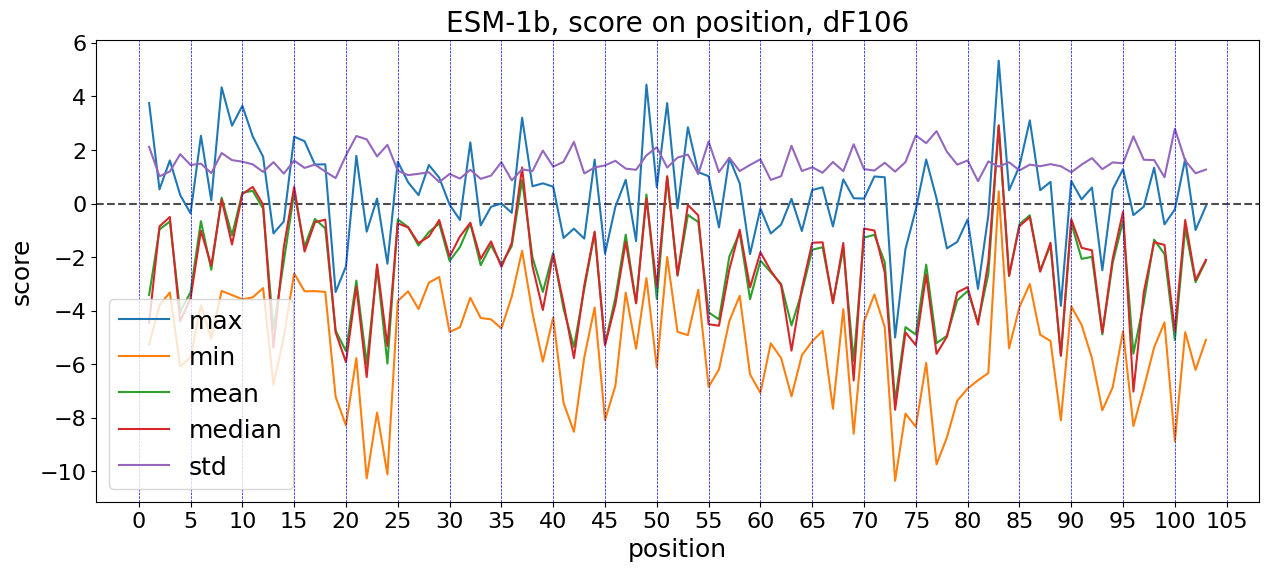

In [27]:
# Protein1
title = f"{output_name}, score on position, {protein1['name']}"
score_on_position(protein1, options_difference_on_position, title, output_name, save_as)

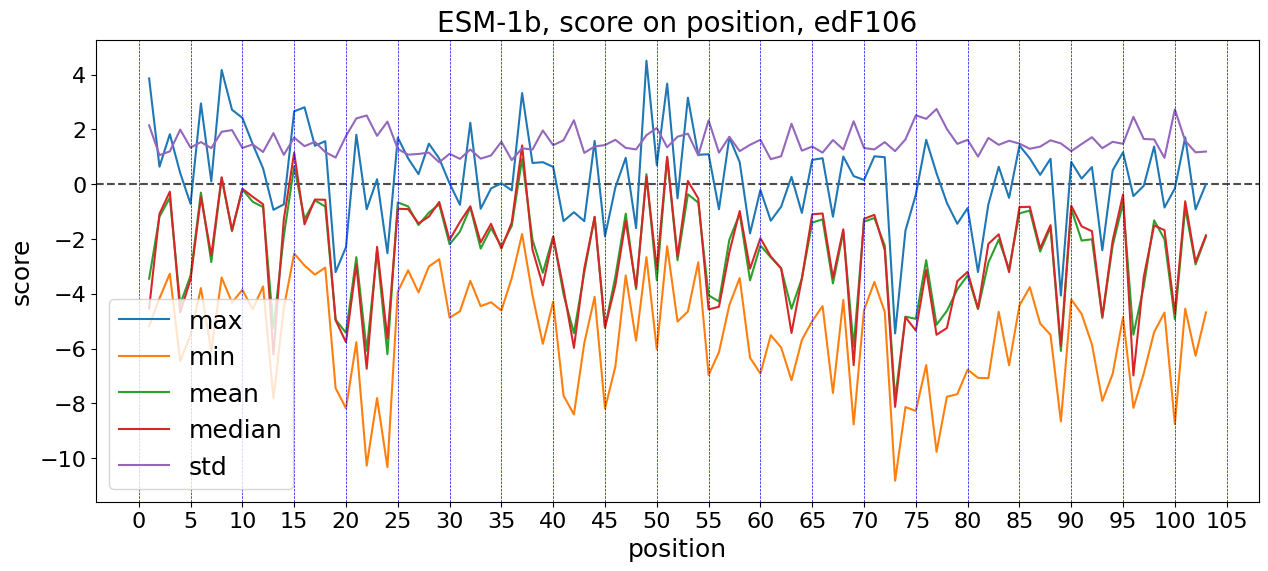

In [28]:
# Protein2
title = f"{output_name}, score on position, {protein2['name']}"
score_on_position(protein2, options_difference_on_position, title, output_name, save_as)

### Score difference on position

In [29]:
def compute_differences(df_prot1, df_prot2, changed_positions):
    # Count difference between the scores
    scores1, scores2 = df_prot1["score"], df_prot2["score"]

    df_merged = pd.merge(
                        df_prot1, df_prot2,
                        on=['from', 'position', 'to'],
                        suffixes=('_1', '_2')
    )

    # Don't use changed positions for the differences
    df_merged = df_merged[~df_merged["position"].isin(changed_positions)]

    df_merged["diff"] = df_merged['score_1'] - df_merged['score_2']

    return df_merged[["diff", "position"]]

def difference_on_position(protein1, protein2, options, changed_positions=None, output_name=None, save_as=None):
    """options can have these `['max', 'min', 'mean', 'median']`"""
    # Maybe minimal and maximal difference on each position?
    # Some graphs specific for some aminoacids?

    title_size = 20
    label_size = 18
    tick_size = 16

    # Compute differences:
    df_differences = compute_differences(protein1["result"], protein2["result"], changed_positions)

    # Count what is the sum absolute difference in scores
    print("Sum:", df_differences["diff"].sum())

    # Count what is the mean absolute difference in scores
    print("Mean:", df_differences["diff"].mean())

    # Count STD
    print("Std.:", df_differences["diff"].std())

    scores_on_position = []
    positions = []
    for i in range(len(protein1["sequence"])):
        if len(df_differences[df_differences["position"] == i]) > 0:
            scores_on_position.append(df_differences[df_differences["position"] == i]["diff"])
        else:
            scores_on_position.append([np.NAN])
        positions.append(i)

    min_on_position    = np.array([np.array(scores).min()  for scores in scores_on_position])
    max_on_position    = np.array([np.array(scores).max()  for scores in scores_on_position])
    mean_on_position   = np.array([np.array(scores).mean() for scores in scores_on_position])
    median_on_position = np.array([np.median(scores)       for scores in scores_on_position])
    std_on_position    = np.array([np.std(scores)          for scores in scores_on_position])

    import matplotlib.pyplot as plt

    plt.figure(figsize=(15, 6))

    plt.axhline(y=0, color="black", linestyle='--', alpha=0.7)

    if "max" in options:
        plt.plot(positions, max_on_position,    label="max")
    if "min" in options:
        plt.plot(positions, min_on_position,    label="min")
    if "mean" in options:
        plt.plot(positions, mean_on_position,   label="mean")
    if "median" in options:
        plt.plot(positions, median_on_position, label="median")
    if "std" in options:
        plt.plot(positions, std_on_position,    label="std")
    if len(options) == 0:
        raise Exception("No options passed to the function.")

    # Plot where positions were changed:
    if len(changed_positions) != 0:
        plt.axvline(x=changed_positions[0], color='r', linestyle='-', linewidth=1, label='changed positions')
        for i in changed_positions:
            plt.axvline(x=i, color='r', linestyle='-', linewidth=1)
    
    # Make it more clear
    ticks = np.arange(start=0, stop=106, step=5)
    plt.xticks(ticks)
    for i in ticks:
        plt.axvline(x=i, color='b', linestyle='--', linewidth=0.5)
    
    plt.xlabel("position in sequence", fontsize=label_size)
    plt.ylabel("difference of scores", fontsize=label_size)
    plt.title(output_name +", difference on position, "+protein1["name"]+", "+protein2["name"], fontsize=title_size)
    plt.tick_params(axis='both', labelsize=tick_size)

    plt.legend(fontsize=label_size)

    if save_as==None:
        plt.show()
    else:
        plt.savefig(save_as+"_diff.png")



Sum: 94.06167989969254
Mean: 0.04610866661749634
Std.: 0.2698253032466358


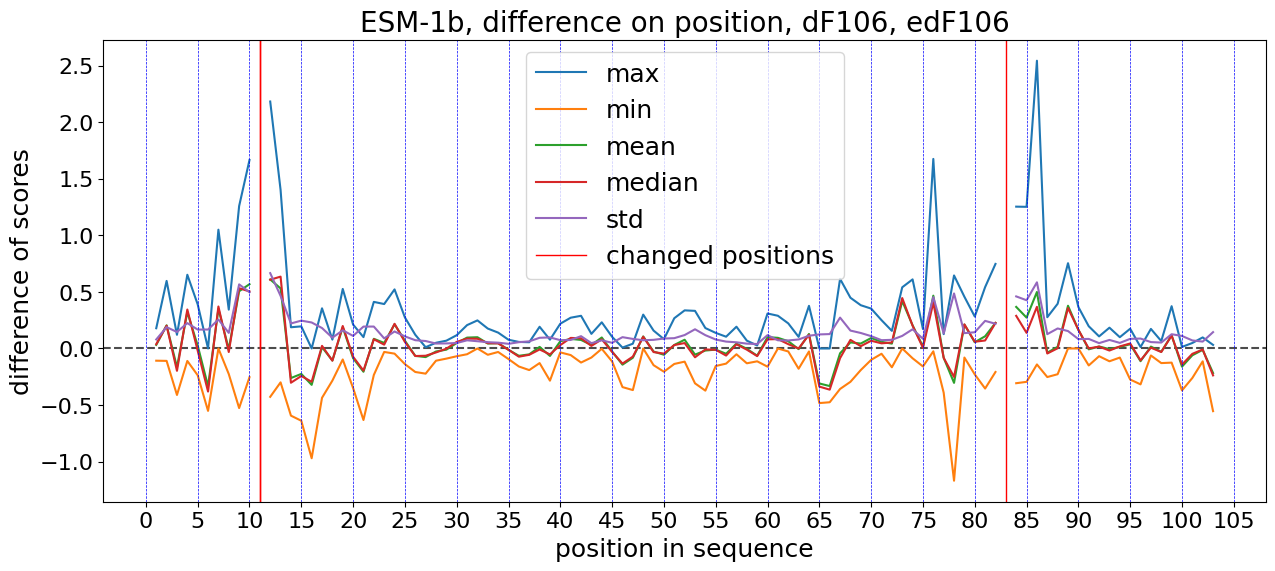

In [30]:
# Max error difference on each position
difference_on_position(protein1, protein2, options_difference_on_position, changed_positions, output_name, save_as)